In [6]:
## import libraries
import os
import sys
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import _pickle as pickle
import matplotlib.pyplot as pyplot
import theano
from nolearn.lasagne import BatchIterator
from collections import OrderedDict
from sklearn.base import clone

In [2]:
# change the directory to where you put the datasets

FTRAIN = '~/Facial_KeyPoints_Detection/training.csv'
FTEST = '~/Facial_KeyPoints_Detection/test.csv'

#FTRAIN = '~/Desktop/W207Final/training.csv'
#FTEST = '~/Desktop/W207Final/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [3]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

Increase hidden unit and epochs since it is not over fit yet:

In [4]:
# increase las two hidden layer from 500 to 1000 and increase max epochs to 10000#
net7 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=10000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net7.fit(X, y)

with open('net7.pickle', 'wb') as f:
    pickle.dump(net7, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.06852     0.03448    1.98734  2.10s
      2     0.01374     0.02240    0.61304  2.10s
      3     0.00960     0.01585    0.60564  2.09s
      4     0.00796     0.01226    0.64953  2.09s
      5     0.00732     0.01010    0.72539  2.10s
      6     0.00702     0.00938    0.74842  2.10s
      7     0.00671     0.00894    0.75044  2.10s
      8     0.00649     0.00800    0.81173  2.10s
      9     0.00642     0.00815    0.78730  2.09s
     10     0.00619     0.00796    0.77791  2.09s
     11     0.00606     0.00775    0.78185  2.09s
     12     0.00597     0.00745    0.80118  2.09s
     13     0.00586     0.00729    0.80393  2.09s
     14     0.00582     0.00711    0.81928  2.09s
     15     0.00575     0.00699    0.82345  2.09s
     16     0.00567     0.00672    0.84422  2.09s
     17     0.00560     0.00664    0.84264  2.09s
     18     0.00559     0.00669    0.83594  2.09s
  

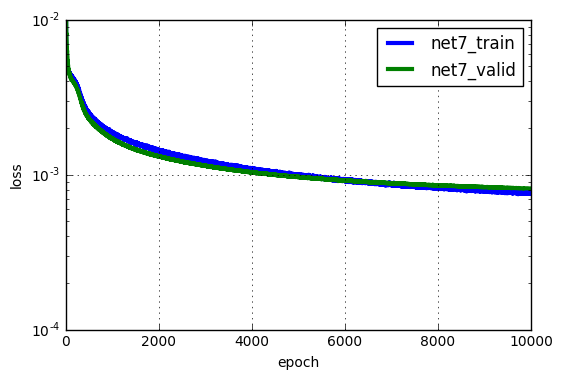

In [7]:
# plot
net7_train_loss = np.array([i["train_loss"] for i in net7.train_history_])
net7_valid_loss = np.array([i["valid_loss"] for i in net7.train_history_])
pyplot.plot(net7_train_loss, linewidth=3, label="net7_train")
pyplot.plot(net7_valid_loss, linewidth=3, label="net7_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

In [5]:
# calculate Kaggle score for this model
np.sqrt(0.00081)*48 # normalize to [-1,1]

1.3661039491927398

Training in special lists:

In [4]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [14]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]


def fit_specialists(fname_pretrain=None):
    if fname_pretrain:  # !
        with open(fname_pretrain, 'rb') as f:  # !
            net_pretrain = pickle.load(f)  # !
    else:  # !
        net_pretrain = None  # !

    specialists = OrderedDict()

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net_pretrain)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        model.max_epochs = int(4e6 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        if net_pretrain is not None:  # !
            # if a pretrain model was given, use it to initialize the
            # weights of our new specialist model:
            model.load_params_from(net_pretrain)  # !

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model

    with open('net-specialists.pickle', 'wb') as f:
        # this time we're persisting a dictionary with all models:
        pickle.dump(specialists, f, -1)

In [ ]:
# increase las two hidden layer from 500 to 1000 and increase max epochs to 10000#
net8 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=10000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

fit_specialists(fname_pretrain='net7.pickle')

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2 

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


      1     0.12424     0.00082  152.16610  2.21s
  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.12424     0.00082  152.16610  2.21s
      2     0.09298     0.04546    2.04531  2.20s
      2     0.09298     0.04546    2.04531  2.20s
      3     0.06878     0.06228    1.10445  2.19s
      3     0.06878     0.06228    1.10445  2.19s
      4     0.06539     0.06176    1.05887  2.19s
      4     0.06539     0.06176    1.05887  2.19s
      5     0.06423     0.05623    1.14227  2.19s
      5     0.06423     0.05623    1.14227  2.19s
      6     0.06379     0.06251    1.02055  2.19s
      6     0.06379     0.06251    1.02055  2.19s
      7     0.06317     0.06777    0.93218  2.19s
      7     0.06317     0.06777    0.93218  2.19s
      8     0.06333     0.06499    0.97450  2.20s
      8     0.06333     0.06499    0.97450  2.20s
      9     0.06301     0.05612    1.12277  2.20s
      9     0.06301     0.05612    1.12277  2.20s
  

/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Loaded parameters to layer 'output' (shape 1000x30).
Loaded parameters to layer 'output' (shape 30).
Training model for columns ('nose_tip_x', 'nose_tip_y') for 1869 epochs
# Neural Network with 16561502 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


      1     0.14359     0.00082  175.76522  2.21s
  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.14359     0.00082  175.76522  2.21s
      2     0.10673     0.06632    1.60933  2.19s
      2     0.10673     0.06632    1.60933  2.19s
      3     0.07788     0.07442    1.04661  2.19s
      3     0.07788     0.07442    1.04661  2.19s
      4     0.07500     0.06181    1.21327  2.19s
      4     0.07500     0.06181    1.21327  2.19s
      5     0.07444     0.07057    1.05479  2.19s
      5     0.07444     0.07057    1.05479  2.19s
      6     0.07355     0.06403    1.14871  2.20s
      6     0.07355     0.06403    1.14871  2.20s
      7     0.07304     0.06919    1.05561  2.19s
      7     0.07304     0.06919    1.05561  2.19s
      8     0.07303     0.06864    1.06410  2.19s
      8     0.07303     0.06864    1.06410  2.19s
      9     0.07314     0.07428    0.98471  2.19s
      9     0.07314     0.07428    0.98471  2.19s
  